# Imports

In [1]:
from csv import reader
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
from random import sample
from scipy import mean
from scipy.stats import sem, t, ttest_ind
import pandas as pd
from Bio import Align
from Bio.SubsMat import MatrixInfo
from sklearn.manifold import TSNE
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import scipy.cluster.hierarchy as hc
import scipy.spatial as sp
from sklearn.feature_selection import f_regression

# Object Definition

## Clonotype

So this object will hold clonotype information. This can be parsed either from the MiXCR assemble output, which has more information, or from VDJTools Convert output, which is more congruous with the analysis pipeline. Will first write parser for VDJTools.

In [4]:
class clonotype( object ):
    
    def __init__( self, entry, count, source="vdjtools" ):
        # Assign the clonotype a unique ID.
        self.id = count
        
        if source == "vdjtools":
            # Parse the data from the clonotype table line
            entry_split = entry.split( "\t" )
            self.count = int( entry_split[0] )
            self.freq = float( entry_split[1] )
            self.cdr3nt = entry_split[2]
            self.cdr3nt_length = len( self.cdr3nt )
            self.cdr3aa = entry_split[3]
            self.cdr3aa_length = len( self.cdr3aa )
            self.v_segment = entry_split[4]
            self.d_segment = entry_split[5]
            self.j_segment = entry_split[6]
            self.v_end = int( entry_split[7] )
            self.d_start = int( entry_split[8] )
            self.d_end = int( entry_split[9] )
            self.j_start = int( entry_split[10] )
            
            # Determine whether the clonotype represents a alpha or beta chain.
            self.chain = "A" if "A" in self.v_segment else "B"
            
        elif source == "immuneACCESS":
            # Parse the data from the clonotype table line.
            # Unlike with vdjtools format, CDR3 region is not spelled out in table. But we don't need the 
            # sequence right now.
            entry_split = entry.split( "\t" )
            
            # I've found immuneACCESS files which contain negative counts, so just catch those real quick.
            self.count = abs( int( entry_split[2] ) )
            self.freq = float( entry_split[3] )
            self.cdr3nt = entry_split[0]
            self.cdr3nt_length = int( entry_split[4] )
            self.cdr3aa = entry_split[1]
            self.cdr3aa_length = len( self.cdr3aa )
            self.v_segment = entry_split[7]
            self.d_segment = entry_split[14]
            self.j_segment = entry_split[21]
            self.functional = entry_split[38] == "In"
            
            self.chain = "A" if "A" in self.v_segment else "B"
            
        elif source == "comparitor":
            self.count = entry[0]
            self.freq = entry[1]
            self.scope = entry[2]
            
        else:
            exit( "{} is not an acceptable format. Unable to parse line.".format( format ) )
    
    # strict: CDR3nt and V segment and J segment
    # nt: CDR3nt 
    # ntV: CDR3nt and V segment 
    # ntVJ: CDR3nt and V and J 
    # aa: CDR3aa
    # aaV: CDR3aa and V
    # aaVJ: CDR3aa and V and J 
    # aa!nt: CDR3aa and CDR3nt
    def generate_scope( self, scope="strict" ):
        if scope == "strict":
            self.scope = "{}.{}.{}".format( self.cdr3nt, self.v_segment, self.j_segment )
        elif scope == "nt":
            self.scope = "{}".format( self.cdr3nt )
        elif scope == "ntV":
            self.scope = "{}.{}".format( self.cdr3nt, self.v_segment )
        elif scope == "ntVJ":
            self.scope = "{}.{}.{}".format( self.cdr3nt, self.v_segment, self.j_segment )
        elif scope == "aa":
            self.scope = "{}".format( self.cdr3aa )
        elif scope == "aaV":
            self.scope = "{}.{}".format( self.cdr3aa, self.v_segment )
        elif scope == "aaVJ":
            self.scope = "{}.{}.{}".format( self.cdr3aa, self.v_segment )
        elif scope == "aa!nt":
            self.scope = "{}.{}".format( self.cdr3aa, self.cdr3nt )
        
        return( self.scope )
            
    def __repr__( self ):
        if self.chain == "A":
            return "Clonotype {} observed {} times: {} | {} | {}".format( self.id,
                                                                          self.count, 
                                                                          self.v_segment,
                                                                          self.cdr3aa,
                                                                          self.j_segment )
        else:
            return "Clonotype {} observed {} times: {} | {} | {} | {}".format( self.id,
                                                                               self.count, 
                                                                               self.v_segment,
                                                                               self.cdr3aa,
                                                                               self.d_segment,
                                                                               self.j_segment )

## Repertoire
This object holds a list of clonotypes and any analysis performed on them.

In [5]:
class repertoire( object ):
    
    # Essentially just pass input file to clonotype parser
    def __init__( self, name, file=None, source="vdjtools", constructed_repertoire=None ):
        
        self.name = name
        if file is None:
            self.clonotypes = constructed_repertoire
        else:
            self.clonotypes = list()
            count = 1

            # Open the file and parse into a list of clonotype objects
            with open( file, "r" ) as clonotype_file:

                # Skip the header line
                next( clonotype_file )

                # Iterate through lines, each line should be a clonotype.
                for line in clonotype_file:
                    self.clonotypes.append( clonotype( line, count, source ) )
                    count += 1

            self.update_frequencies()
    
    def subset( self, chain="All", functional=True ):
        if chain != "All":
            clonotypes_temp = [i for i in self.clonotypes if i.chain == chain]
            self.clonotypes = clonotypes_temp
        
        if functional:
            clonotypes_temp = [i for i in self.clonotypes if i.functional]
            self.clonotypes = clonotypes_temp
        
        self.update_frequencies()
    
    # The frequencies in the file are often slightly incorrect. Correct them so that they're correct in context.
    def update_frequencies( self ):
        total_chains_a = sum( [i.count for i in self.clonotypes if i.chain == "A"] )
        total_chains_b = sum( [i.count for i in self.clonotypes if i.chain == "B"] )
        
        for i in self.clonotypes:
            i.freq = i.count / ( total_chains_a if i.chain == "A" else total_chains_b )
    
    # Calculates the parameterized Rényi’s definition of generalized entropy. 
    def calculate_diversity( self, alpha, clones=None, verbose=False ):
        if clones is None:
            clones = self.clonotypes
        
        
        # Alpha == 1 in undefined in the actual definition, but tends towards Shannon entropy so we use that as a special case. 
        if alpha == 1:
            return( -1 * sum( [i.freq * math.log( i.freq ) for i in clones] ) )
        else:
            try:
                return( math.log( math.pow( sum( [math.pow( i.freq, alpha ) for i in clones] ), 1.0 / ( 1.0 - alpha ) ) ) )
            except ValueError:
                print( "alpha: {}, \n {}".format( alpha, len( [i.freq for i in clones] ) ) )
                sys.exit(69)
                
    # Calculates diversity for a range of alpha values. Default values are taken from paper.
    def calculate_diversity_profile( self, start_alpha=0, end_alpha=10, step=0.2, verbose=False ):
        # Check to see if multiple chains are present in the clonotype list. Show warning if there is.
        # Multiple chains leads to odd results given how we calculate frequency.
        chains_present = list()
        for i in self.clonotypes:
            if i.chain not in chains_present:
                chains_present.append( i.chain )
        if len( chains_present ) > 1:
            print( "Multiple chains present. Results may be misleading. Considering subsetting repertoire with subset()")
            print( chains_present )
        # numpy.arange creates a list of values [start_alpha, end_alpha) so you have to add a step to get what you really want.
        self.diversity_alpha = np.arange( start_alpha, end_alpha + step, step )
        self.diversity = list()
        
        # Calculate diversity at each alpha specified 
        for i in self.diversity_alpha:
            self.diversity.append( self.calculate_diversity( i, verbose=verbose ) )
            
        # Diversity is only one aspect of a diversity. We also need to calculate eveness.
        # Evenness at alpha a is equal to Da=0 / Da.
        species_richness = self.calculate_diversity( 0 )
        self.eveness = list()
        for i in self.diversity:
            self.eveness.append( i / species_richness )
            
    def calculate_rarefaction( self, intervals=101, iterations=100 ):
        
        # Clonotypes are collapsed already, so we need to expand them.
        clones = list()
        for clone in self.clonotypes:
            for indiv in range( clone.count ):
                clones.append( clone.id )
        
        # Select subsampling locations to calculate how species richness changes.
        self.rarefaction_intervals = np.round( np.linspace( 1, len( clones ), intervals ), 0 )
        self.rarefaction = list()
        self.rarefaction_error = list()
        for i in self.rarefaction_intervals:
            rarefaction_temp = list()
            for j in range( iterations ):
                # We want to calculate species richness at each level and thats calculated when alpha = 0. 
                # Well technically species richness is just the number of species observed, so we don't need to
                # mess with all those extra calculations.
                rf_temp = len( np.unique( sample( clones, int( i ) ) ) )
                rarefaction_temp.append( rf_temp )
                
            std_err = sem( rarefaction_temp )
            self.rarefaction.append( mean( rarefaction_temp ) )
            self.rarefaction_error.append( std_err * t.ppf( ( 1 + 0.95 ) / 2, iterations - 1 ) )
        
        self.rarefaction = np.asarray( self.rarefaction )
        self.rarefaction_error = np.asarray( self.rarefaction_error )
        self.rarefaction_intervals = np.asarray( self.rarefaction_intervals )
    
    # Maybe better to just parse these from the VDJTools output.
    def calculate_diversity_statistics( self, print_pretty=True ):
        self.diversity_stats = dict()
        self.diversity_stats["species_richness"] = len( self.clonotypes )
        
        # Chao1 estimator
        total_clones = sum( [i.count for i in self.clonotypes] )
        singletons = sum( [i.count for i in self.clonotypes if i.count == 1] )
        doubletons = sum( [i.count for i in self.clonotypes if i.count == 2] )
        self.diversity_stats["chao1"] = total_clones + ( singletons * ( singletons - 1 ) ) / ( 2 * ( doubletons + 1 ) )
        
        if print_pretty:
            print( "Species Richness: {}".format( self.diversity_stats["species_richness"] ) )
            print( "\nLower bound total diversity estimate: " )
            print( "Chao1: {}".format( self.diversity_stats["chao1"] ) )
            
    # Calculate inter-sample comparison by means of a supplied matrix. Aligning sequences with 
    # Bio.Align.PairwiseAligner as its the fastest aligner provided by biopython.
    def calculate_similarity_matrix( self, matrix ):
        # This really only works for in-frame receptors so subset them. Remove receptors
        # where either the cdr3 region can't be determined, or contains stop codons.
        inframe_repertoire = [i.cdr3aa for i in self.clonotypes if len( i.cdr3aa ) > 0]
        inframe_repertoire = [i for i in inframe_repertoire if "*" not in i]
        inframe_repertoire = [i for i in inframe_repertoire if "_" not in i]
        
        # Set Aligner parameters according to Yokota et al. Also just pretty standard protein alignment.
        # Any matrix will do, I should find some way of determining what matrix is best.
        aligner = Align.PairwiseAligner()
        aligner.substitution_matrix = matrix
        aligner.mode = "local"
        aligner.open_gap_score = -10
        aligner.extend_gap_score = -1
        
        # Create an empty matrix with length equal to the number of clonotypes in repertoire.
        self.pairwise_distances = np.zeros( ( len( inframe_repertoire ), len( inframe_repertoire ) ) )
    
        # Compare every clonotype with every other clonotype.
        for i, sequenceA in enumerate( inframe_repertoire ):
            for j, sequenceB in enumerate( inframe_repertoire ):
                
                # The distance from A to B should be equal to the distance from B to A, and we don't want
                # to calculate that twice.
                if j >= i:
                    pairwise_distance = aligner.score( sequenceA, sequenceB )
                    self.pairwise_distances[j,i] = pairwise_distance
                    self.pairwise_distances[i,j] = pairwise_distance
        return( self.pairwise_distances, inframe_repertoire )
    
    # Create the dissimilarity matrix to be used for dimensionality reduction
    # Not quite correct yet as evident by the fact that 1.5% of values are negative.
    def calculate_dissimilarity_matrix( self, matrix ):
        sim_matrix, ifr = self.calculate_similarity_matrix( matrix )
        self.dissimilarity_matrix = np.zeros( ( len( sim_matrix ), len( sim_matrix ) ) )
        for i, row in enumerate( sim_matrix ):
            for j, distance in enumerate( row ):
                if j >= i:
                    dissimilarity = 1 - ( ( 2 * distance ) / ( sim_matrix[i,i] + sim_matrix[j,j] ) )
                    
                    if dissimilarity < 0:
                       print( "Error: {} vs {}, D: {}".format( ifr[i], ifr[j], dissimilarity ) )
                    
                    self.dissimilarity_matrix[j,i] = dissimilarity
                    self.dissimilarity_matrix[i,j] = dissimilarity
    
    def get_size( self ):
        return( sum( [i.count for i in self.clonotypes ] ) )
    
    def __len__( self ):
        return( len( self.clonotypes ) )
            

## Comparitor

In [6]:
class comparitor( object ):
    
    def __init__( self, repertoireA, repertoireB, scope="strict" ):
        self.repertoireA = repertoireA
        self.repertoireB = repertoireB
        
        self.collapse( scope )
        
    def scope_count_dict( self, scope, rep ):
        return_dict = dict()
        for i in rep.clonotypes:
            i_scope = i.generate_scope( scope )
            if i in return_dict:
                return_dict[i_scope] += i.count
            else:
                return_dict[i_scope] = i.count
        return( return_dict )
    
    def generate_clonotypes( self, repertoire_dict ):
        return_list = list()
        repetoire_total = sum( repertoire_dict.values() )
        for i, j in repertoire_dict.items():
            clonotype_defintion = [j, j/repetoire_total, i]
            return_list.append( clonotype( clonotype_defintion, 0, source="comparitor" ) )
        return( return_list )
    
    def collapse( self, scope ):
        # Collapse repertoire based on scope.
        self.repertoireA_dict = self.scope_count_dict( scope, self.repertoireA )
        self.repertoireB_dict = self.scope_count_dict( scope, self.repertoireB )
        
        self.repertoireA = repertoire( constructed_repertoire=self.generate_clonotypes( self.repertoireA_dict ) )
        
        self.repertoireB = repertoire( constructed_repertoire=self.generate_clonotypes( self.repertoireB_dict ) )
        
    def sequence_convergence( self ):
        overlap = np.intersect1d( [i.scope for i in self.repertoireA.clonotypes], [i.scope for i in self.repertoireB.clonotypes] )
        minimum = min( len( self.repertoireA ), len( self.repertoireB ) )
        average = ( len( self.repertoireA ) + len( self.repertoireB ) ) / 2
        maximum = max( len( self.repertoireA ), len( self.repertoireB ) )
        union = len( np.union1d( [i.scope for i in self.repertoireA.clonotypes], [i.scope for i in self.repertoireB.clonotypes] ) )
        
        # Metric giving more weight to smaller repertoires
        self.min_overlap = ( len( overlap ) / minimum ) * 100
        
        # Metric equally weighing both repertoires
        self.mean_overlap = ( len( overlap ) / average ) * 100
        
        # Metric giving more weight to larger repertoires
        self.max_overlap = ( len( overlap ) / maximum ) * 100
        
        # Jaccard Index
        self.jaccard_index = ( len( overlap ) / union ) * 100
        
    # Calculates power-geometric index based on implementation in divo R library. 
    # Note: I have no way of testing this.
    def power_geometric_index( self, alpha, beta=None, corrected=False ):
        
        # You can do funky things with alpha and beta to create a 3D overlap profile instead of a 2D one.
        if beta is None:
            beta = alpha
        
        sumA = sum( self.repertoireA_dict.values() )
        sumB = sum( self.repertoireB_dict.values() )
        
        if not corrected:
            
            term1 = 0.0
            term2 = 0.0
            term3 = 0.0
            term4 = 0.0
            
            for i in set( self.repertoireA_dict.keys() ).intersection( self.repertoireB_dict.keys() ):
                term1 += math.pow( self.repertoireA_dict[i] / sumA, alpha ) * math.pow( self.repertoireB_dict[i] / sumB, beta )
                term2 += math.pow( self.repertoireB_dict[i] / sumB, alpha ) * math.pow( self.repertoireA_dict[i] / sumA, beta )
                term3 += math.pow( self.repertoireA_dict[i] / sumA, alpha + beta )
                term4 += math.pow( self.repertoireB_dict[i] / sumB, alpha + beta )
            return( ( term1 + term2 ) / ( term3 + term4 ) )
        
        else:
            
            numerator = 0.0
            denominator = 0.0
            
            ptrPaA = 0.0
            ptrPaB = 0.0
            
            ptrAbcA = 0.0
            ptrAbcB = 0.0
            
            # I only have a tangential idea what this variable means.
            dpA = len( [ i for i in self.repertoireA_dict.values() if i == 1] )
            dpB = len( [ i for i in self.repertoireB_dict.values() if i == 1] )
            
            dpA -= 1 if dpA == sumA else 0
            dpB -= 1 if dpB == sumB else 0
            
            for i in set( self.repertoireA_dict.keys() ).intersection( self.repertoireB_dict.keys() ):
                
                ptrPaA = ( self.repertoireA_dict[i] / sumA ) * ( 1.0 - ( dpA / sumA ) )
                ptrPaB = ( self.repertoireB_dict[i] / sumB ) * ( 1.0 - ( dpB / sumB ) )
                
                ptrAbcA = 1.0 - math.pow( 1 - ptrPaA, sumA )
                ptrAbcB = 1.0 - math.pow( 1 - ptrPaB, sumB )
                
                ptrAbcA = 1.0 if ptrAbcA == 0 else ptrAbcA
                ptrAbcB = 1.0 if ptrAbcB == 0 else ptrAbcB
                
                numerator += ( math.pow( ptrPaA, alpha ) * math.pow( ptrPaB, beta ) ) / ( ptrAbcA * ptrAbcB )
                denominator += math.pow( ptrPaA, 2 * alpha ) + ptrAbcA + math.pow( ptrPaB, 2 * beta ) / ptrAbcB
                    
            return( 2 * numerator / denominator )
        
    def generate_overlap_profile( self, start_alpha=0, end_alpha=10, step=0.2 ):
        self.overlap_alphas = np.arange( start_alpha, end_alpha + step, step )
        self.overlap = list() 
        self.overlap_corrected = list()
        
        for i in self.overlap_alphas:
            self.overlap.append( self.power_geometric_index( alpha=i, corrected=False ) )
            self.overlap_corrected.append( self.power_geometric_index( alpha=i, corrected=True ) )
            
    

# Pre-processing

Load the samples in calculate basic diversity profiles. Sample 40 is dropped because its repertoire contains only 
7000 clones, significantly lower than other samples, and is throwing off analysis.

Data source: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0178167

In [7]:
HPV_repes = [ "01_1",
             "02",
             "03",
             "05",
             "06",
             "07_1",
             "08",
             "09_1",
             "10",
             "11_1",
             "12",
             "13",
             "14",
             "15",
             "16",
             "17_1",
             "18",
             "19",
             "20_1",
             "21",
             "22",
             "23",
             "24",
             "25",
             "26",
             "27",
             "28",
             "29",
             "30",
             "31",
             "32",
             "33",
             "34_1",
             "35",
             "36",
             "37_1",
             "38",
             "39",
             "41",
             "42",
             "43",
             "44_1",
             "45",
             "46",
             "47",
             "48",
             "49_1",
             "50" ]

repertoire_list = list()
for i in HPV_repes:
    tempertoire = repertoire( i, "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/Vercingetorix/input/sampleExport.2019-06-17_11-06-30/{}.tsv".format( i ), source="immuneACCESS" )
    tempertoire.subset( "B", functional=True )
    tempertoire.calculate_diversity_profile( end_alpha=10 )
    repertoire_list.append( tempertoire )
    

Then we can load in the metadata.

In [8]:
HPV_metadata = pd.read_csv( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/Vercingetorix/input/SampleOverview_06-18-2019_4-56-01_PM.tsv", 
                          sep="\t",
                          index_col=0 )
HPV_metadata = HPV_metadata.sort_index()
HPV_metadata = HPV_metadata.loc[HPV_repes]

# Plotting

## QC Plots

In [16]:
def frequency_distribution( data, bins ):
    fig, ax = plt.subplots( figsize=( 5, 5 ), dpi=100 )
    ax.hist( [i.freq for i in data.clonotypes], bins=bins )
    plt.yscale( "log" )
    plt.show()

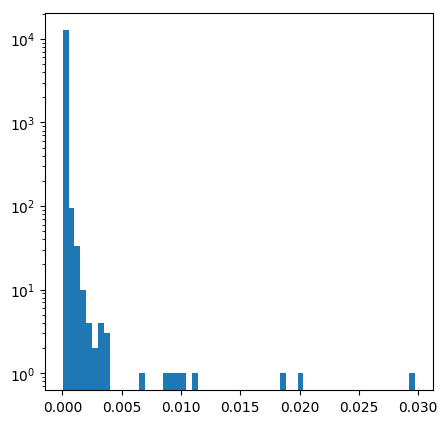

In [25]:
frequency_distribution( repe, 60 )

## Diversity Profile
Plots the diversity profile as calculated by the repertoire object. Takes a number of repertoires and

In [155]:
def diversity_profile_graph( data, labels, cases ):
    if len( data ) != len( labels ):
        print( "Number of labels is not equal to number of repertoires. Fix that!" )
        return()
    
    fig, ax = plt.subplots( 1, 2, figsize=(11, 5), dpi=100 )
    
    # Iterate through data and plot what we can.
    for i, sample in enumerate( data ):
        if cases[i] == 1:
            ax[0].plot( sample.diversity_alpha, sample.diversity, "b", label=labels[i] )
            ax[1].plot( sample.diversity_alpha, sample.eveness, "b", label=labels[i] )
        else:
            ax[0].plot( sample.diversity_alpha, sample.diversity, "r", label=labels[i] )
            ax[1].plot( sample.diversity_alpha, sample.eveness, "r", label=labels[i] )
    
    # Set up the Diversity Profile plot.
    ax[0].set( xlabel=r"$\alpha$", ylabel=r"Diversity ($^\alpha D$)", title="Diversity Profile" )
    ax[0].grid()
    #ax[0].legend()
    
    # Set up the Eveness Profile plot.
    ax[1].set( xlabel=r"$\alpha$", ylabel=r"Eveness ($^\alpha E$)", title="Eveness Profile" )
    #ax[1].legend()
    ax[1].grid()

    plt.show()

Text(0.5, 1.0, 'Diversity Profiles Comparison')

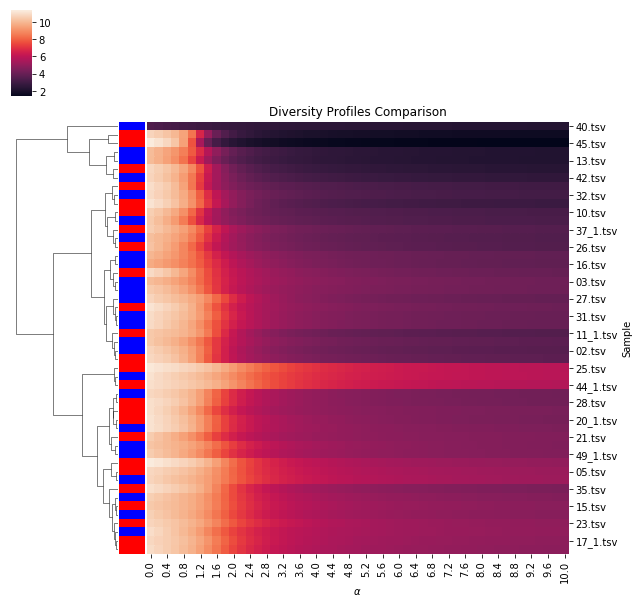

In [220]:
xlabels = ["{:.1f}".format( i ) for i in repertoire_list[1].diversity_alpha]
diversity_profiles = pd.DataFrame( [i.diversity for i in repertoire_list],
                                  columns=xlabels,
                                  index=HPV_repes )
color_list = list()
for i in HPV_repes:
    if i in controls:
        color_list.append( "b" )
    else:
        color_list.append( "r" )


        
#fig, ax = plt.subplots( figsize=(5, 5), dpi=100 )
g = sns.clustermap( diversity_profiles, method="complete", metric="euclidean", col_cluster=False, row_colors=color_list )
g.ax_heatmap.set_ylabel( "Sample" )
g.ax_heatmap.set_xlabel( r"$\alpha$" )
g.ax_heatmap.set_title( "Diversity Profiles Comparison")



/Users/natem/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


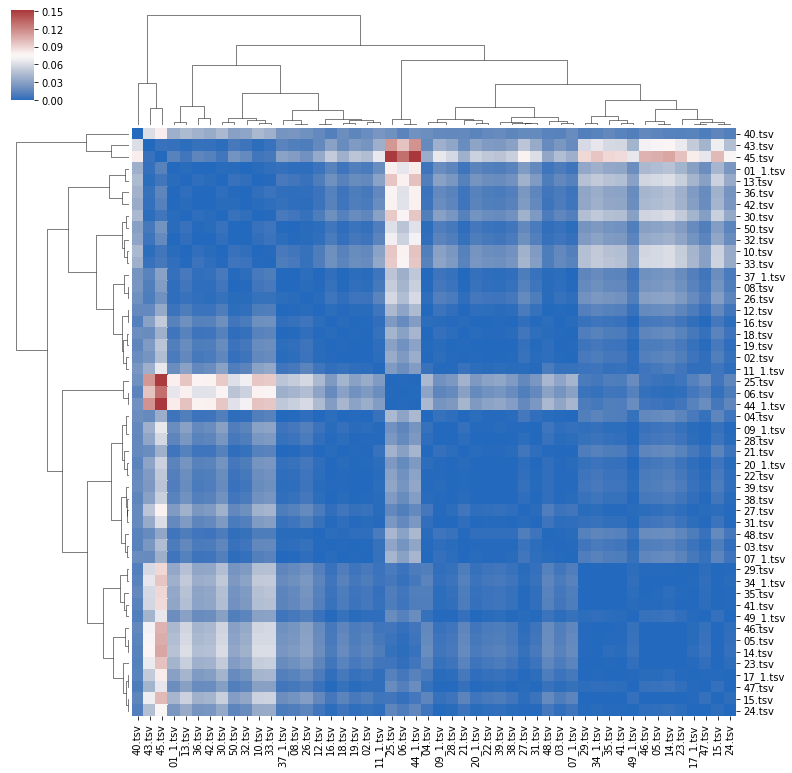

In [260]:
dm = pd.DataFrame( sp.distance_matrix( diversity_profiles.values, diversity_profiles.values ), 
             index=diversity_profiles.index, 
             columns=diversity_profiles.index )

linkage = hc.linkage( dm, method="complete" )

sns.clustermap( dm,
               row_linkage=linkage,
               col_linkage=linkage,
               cmap="vlag", 
               figsize=(13,13) )


In [237]:
diversity_profiles.T.corr()

,01_1.tsv,02.tsv,03.tsv,04.tsv,05.tsv,06.tsv,07_1.tsv,08.tsv,09_1.tsv,10.tsv,...,41.tsv,42.tsv,43.tsv,44_1.tsv,45.tsv,46.tsv,47.tsv,48.tsv,49_1.tsv,50.tsv
01_1.tsv,1.000000,0.990352,0.989471,0.993884,0.954189,0.934854,0.993318,0.997079,0.979668,0.998505,...,0.965774,0.999915,0.996243,0.918825,0.986118,0.956038,0.978994,0.993381,0.978889,0.998743
02.tsv,0.990352,1.000000,0.999221,0.999500,0.985714,0.972476,0.999597,0.997956,0.998005,0.982483,...,0.992008,0.990383,0.976039,0.962177,0.954316,0.987027,0.996998,0.997302,0.997244,0.996046
03.tsv,0.989471,0.999221,1.000000,0.999131,0.987089,0.976180,0.999375,0.997424,0.997423,0.982708,...,0.992759,0.989841,0.974326,0.965996,0.954224,0.987782,0.998124,0.998878,0.997978,0.995115
04.tsv,0.993884,0.999500,0.999131,1.000000,0.981244,0.967341,0.999963,0.999338,0.995721,0.987634,...,0.988451,0.993933,0.981347,0.955816,0.962554,0.982516,0.995321,0.998691,0.995388,0.998109
05.tsv,0.954189,0.985714,0.987089,0.981244,1.000000,0.997146,0.982194,0.973957,0.993996,0.940655,...,0.999063,0.954765,0.926886,0.993920,0.894939,0.999860,0.994947,0.979671,0.995146,0.967611
06.tsv,0.934854,0.972476,0.976180,0.967341,0.997146,1.000000,0.968697,0.958324,0.983817,0.921005,...,0.993462,0.935984,0.903275,0.998977,0.870290,0.995871,0.987211,0.968151,0.986962,0.950315
07_1.tsv,0.993318,0.999597,0.999375,0.999963,0.982194,0.968697,1.000000,0.999199,0.996131,0.986979,...,0.989213,0.993449,0.980538,0.957399,0.961438,0.983378,0.995812,0.998777,0.995848,0.997769
08.tsv,0.997079,0.997956,0.997424,0.999338,0.973957,0.958324,0.999199,1.000000,0.992024,0.992338,...,0.982616,0.997170,0.987590,0.945426,0.971352,0.975387,0.991423,0.998279,0.991427,0.999598
09_1.tsv,0.979668,0.998005,0.997423,0.995721,0.993996,0.983817,0.996131,0.992024,1.000000,0.969080,...,0.997767,0.979804,0.960629,0.976236,0.934022,0.994996,0.998989,0.992944,0.999369,0.988470
10.tsv,0.998505,0.982483,0.982708,0.987634,0.940655,0.921005,0.986979,0.992338,0.969080,1.000000,...,0.953542,0.998667,0.997824,0.903231,0.992864,0.942221,0.969708,0.989117,0.969202,0.994878


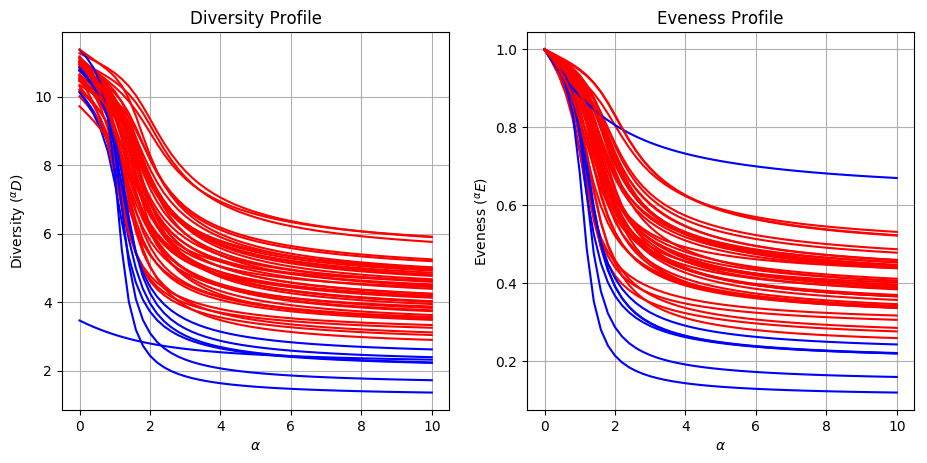

In [162]:
diversity_profile_graph( data=repertoire_list, labels=HPV_repes, cases=clusters.labels_ )

## Rarefaction Analysis

In [8]:
def rarefaction_plot( data, labels ):
    fig, ax = plt.subplots( figsize=( 5, 5 ), dpi=100 )
    for i, sample in enumerate( data ):
        ax.plot( sample.rarefaction_intervals, sample.rarefaction, label=labels[i] )
        ax.fill_between( sample.rarefaction_intervals, sample.rarefaction-sample.rarefaction_error, sample.rarefaction+sample.rarefaction_error, color="grey", alpha=0.2 )
    
    ax.set( xlabel="Chains Observed", ylabel="Unique Clonotypes", title="Rarefaction Curve" )
    ax.grid()
    ax.legend()
    plt.show

In [51]:
#rarefaction_plot( data=[repe, repe2], labels=["106", "110"] )

## Quartile Statistics

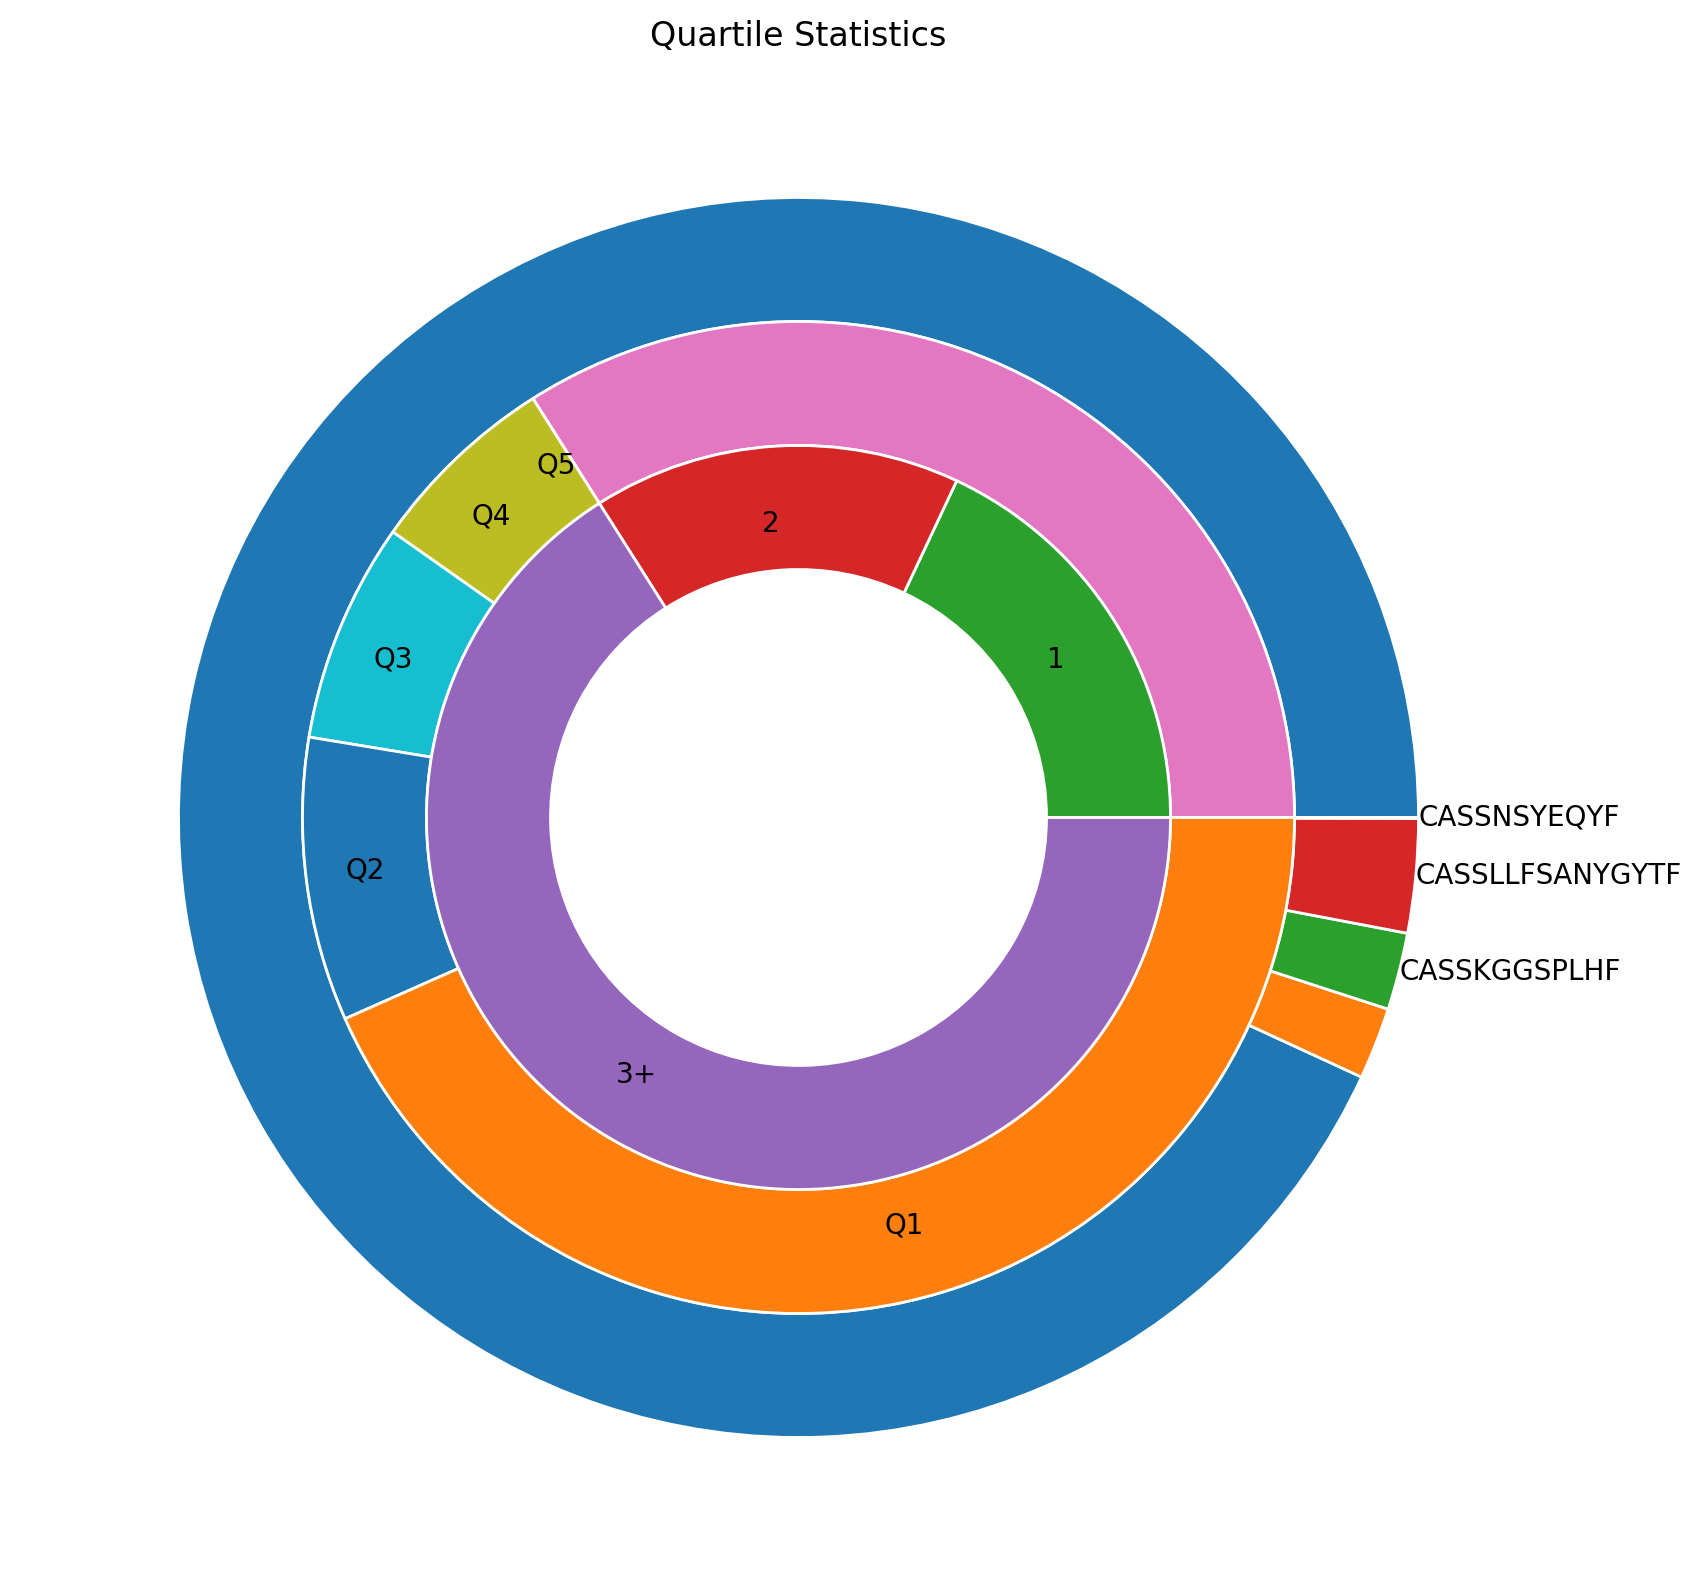

In [49]:
singletons = sum( [i.count for i in repe.clonotypes if i.count == 1] )
doubletons = sum( [i.count for i in repe.clonotypes if i.count == 2] )
everythingelse = [i.count for i in repe.clonotypes if i.count > 2]
everythingelsetons = sum( everythingelse )

fig, ax = plt.subplots( figsize=( 10, 10 ), dpi=200 )
ax.axis( "equal" )
width = 0.2

qb = np.round( np.linspace( 0, len( everythingelse ), 5 ), 0 )
q1 = sum( everythingelse[int(qb[0]):int(qb[1])] )
q2 = sum( everythingelse[int(qb[1]):int(qb[2])] )
q3 = sum( everythingelse[int(qb[2]):int(qb[3])] )
q4 = sum( everythingelse[int(qb[3]):int(qb[4])] )
q5 = sum( everythingelse[int(qb[4]):] )

top_n_clones =[sum( [i.count for i in repe.clonotypes[5:]] )] + [i.count for i in repe.clonotypes[:5][::-1]]
top_n_clones_labels = [""] + [i.cdr3aa for i in repe.clonotypes[:5][::-1]]

pie, _ = ax.pie( top_n_clones, radius=1, labels=top_n_clones_labels, labeldistance=1.0 )
plt.setp( pie, width=width, edgecolor="white" )

pie2, _ = ax.pie( [singletons + doubletons, q5, q4, q3, q2, q1], radius=1-width, labels=["","Q5", "Q4", "Q3", "Q2", "Q1"], labeldistance=0.84 )
plt.setp( pie2, width=width, edgecolor="white" )

pie3, _ = ax.pie( [singletons, doubletons, everythingelsetons], radius=1-(2*width), labels=["1", "2", "3+"], labeldistance=0.79 )
plt.setp( pie3, width=width, edgecolor="white" )

ax.set( title="Quartile Statistics" )

plt.show()

## Spectrotype

In [ ]:
def simple_spectrotype( data, labels, nucleotides=True, xlims=None ):
    fig, ax = plt.subplots( figsize=( 5, 5 ), dpi=100 )
    
    for i, sample in enumerate( data ):
        if nucleotides:
            CDR3_lengths = [i.cdr3nt_length for i in sample.clonotypes]
        else:
            CDR3_lengths = [i.cdr3aa_length for i in sample.clonotypes]
            
        cdr3_hist = [0] * ( max( CDR3_lengths ) + 1 )

        for length in CDR3_lengths:
            cdr3_hist[length] += 1   

        ax.plot( [i for i in range( 0, max( CDR3_lengths ) + 1 )], cdr3_hist, label=labels[i] )

    if xlims is not None:
        ax.set_xlim( xlims )
    ax.legend()
    plt.show()


In [ ]:
simple_spectrotype( data=[repe, repe2], labels=["106", "110"], nucleotides=False, xlims=( 5, 25 ) )

In [ ]:
# Fancy Spectrotype with 

keep_segments = 10

max_length = max( i.cdr3nt_length for i in repe.clonotypes )
v_segment_usage = dict()
for i in repe.clonotypes:
    if i.v_segment in v_segment_usage:
        v_segment_usage[i.v_segment][i.cdr3nt_length] += 1
    else:
        v_segment_usage[i.v_segment] = [0] * ( max_length + 1 )
        v_segment_usage[i.v_segment][i.cdr3nt_length]
        
# Zip the dictionary and sort based on the number clones expressiong the v_segment.        
cd3_lengths, v_segments = ( list( t ) for t in zip( *sorted( zip( v_segment_usage.values(), v_segment_usage.keys() ), key=lambda pair: sum( pair[0] ), reverse=True ) ) )

# Keep only the specified top segments.
top_cd3_lengths = cd3_lengths[:keep_segments][::-1]
top_v_segments = ["Other"] + v_segments[:keep_segments][::-1]

# Sum up the usage of the all segmentrs outside the top.
other_cd3_lengths = cd3_lengths[keep_segments]
for i in cd3_lengths[keep_segments+1:]:
    other_cd3_lengths = [sum( x ) for x in zip( i, other_cd3_lengths )]

# Add the other segments usage to the graphing list.    
top_cd3_lengths = [other_cd3_lengths] + top_cd3_lengths

ny = len( top_cd3_lengths[1] )
ind = list( range( ny ) )

axes = []
cum_size = np.zeros( ny )

data = np.array( top_cd3_lengths )

fig, ax = plt.subplots( figsize=( 5, 5 ), dpi=200 )

for i, row_data in enumerate( data ):
    axes.append( plt.bar( ind, row_data, bottom=cum_size, label=top_v_segments[i] ) )
    cum_size += row_data
    
ax.set_xlim( left=20, right=70 )
plt.ylabel( "Clonotypes" )
plt.legend()
plt.grid()
plt.show() 

## Overlap Profile

In [21]:
def overlap_profile_graph( data, labels ):
    if len( data ) != len( labels ):
        print( "Number of labels is not equal to number of repertoires. Fix that!" )
        return()
    
    fig, ax = plt.subplots( 1, 2, figsize=(11, 5), dpi=100 )
    
    for i, comparison in enumerate( data ):
        ax[0].plot( comparison.overlap_alphas, comparison.overlap, label=labels[i] )
        ax[1].plot( comparison.overlap_alphas, comparison.overlap_corrected, label=labels[i] )
        
    ax[0].set( xlabel=r"$\alpha$", ylabel=r"Overlap ($^\alpha PG$)", title="Uncorrected Overlap Profile" )
    ax[0].grid()
    ax[0].legend() 
    
    ax[1].set( xlabel=r"$\alpha$", ylabel=r"Overlap ($^\alpha PG$)", title="Corrected Overlap Profile" )
    ax[1].grid()
    ax[1].legend()
    
    plt.show()


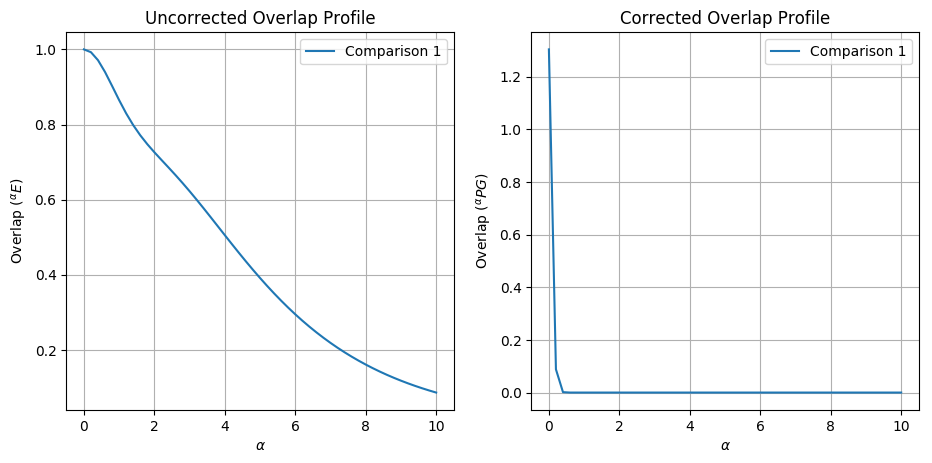

In [20]:
overlap_profile_graph( [comp1], ["Comparison 1"] )

# Comparison

In [6]:
repe.calculate_dissimilarity_matrix( MatrixInfo.blosum65 )

In [8]:
np.sum( repe.dissimilarity_matrix < -0 )

0

In [9]:
X_embedded = TSNE( n_components=2, random_state=42, metric='precomputed', verbose=True ).fit_transform( repe.dissimilarity_matrix )
X_embedded.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13285 samples in 0.083s...
[t-SNE] Computed neighbors for 13285 samples in 2.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13285
[t-SNE] Computed conditional probabilities for sample 2000 / 13285
[t-SNE] Computed conditional probabilities for sample 3000 / 13285
[t-SNE] Computed conditional probabilities for sample 4000 / 13285
[t-SNE] Computed conditional probabilities for sample 5000 / 13285
[t-SNE] Computed conditional probabilities for sample 6000 / 13285
[t-SNE] Computed conditional probabilities for sample 7000 / 13285
[t-SNE] Computed conditional probabilities for sample 8000 / 13285
[t-SNE] Computed conditional probabilities for sample 9000 / 13285
[t-SNE] Computed conditional probabilities for sample 10000 / 13285
[t-SNE] Computed conditional probabilities for sample 11000 / 13285
[t-SNE] Computed conditional probabilities for sample 12000 / 13285
[t-SNE] Computed conditional probabilities for sam

(13285, 2)

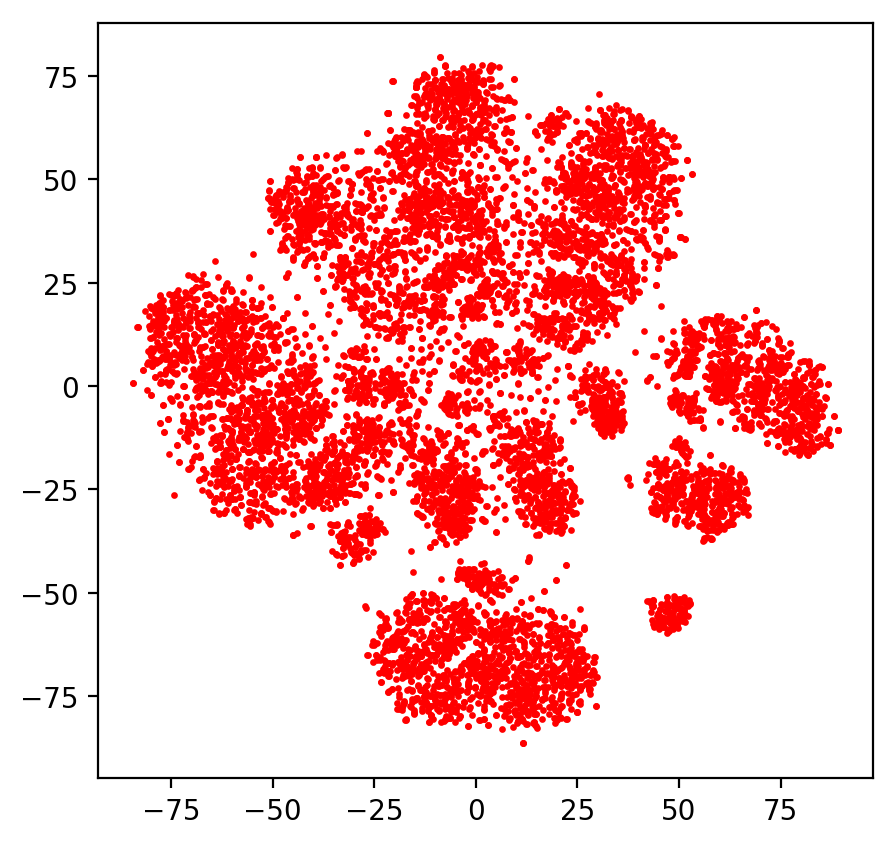

In [47]:
#Literature Data
fig, ax = plt.subplots( figsize=(5, 5), dpi=200 )
ax.scatter( X_embedded[:,0], X_embedded[:,1], s=2, c="r" )

plt.show()

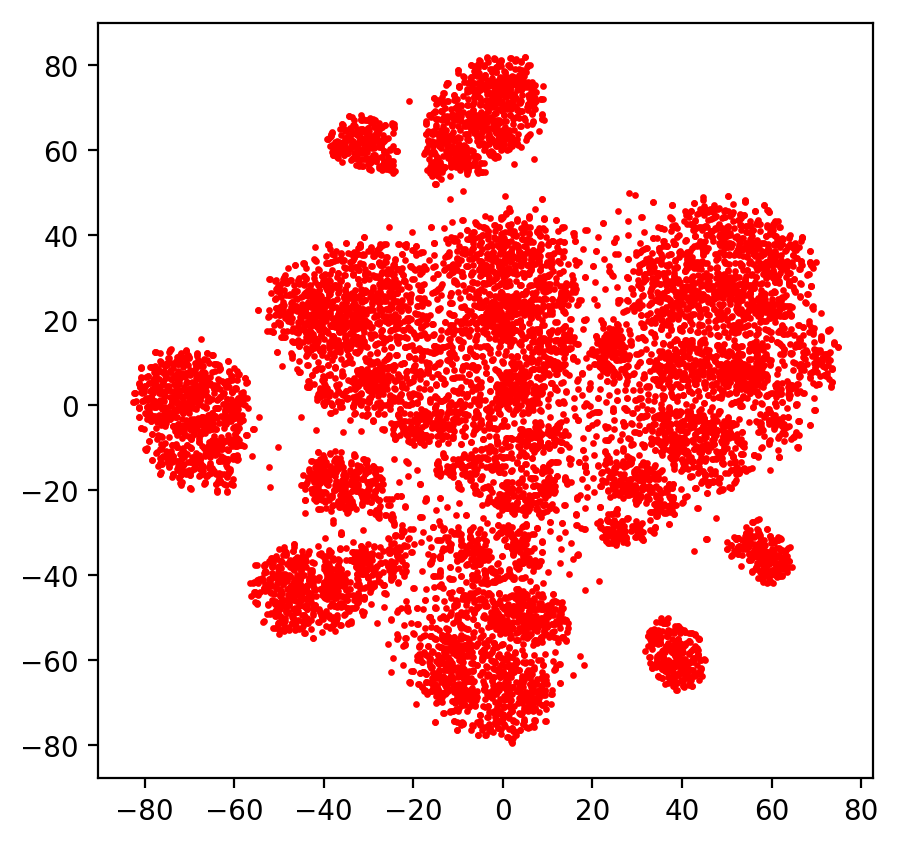

In [10]:
# My data

fig, ax = plt.subplots( figsize=(5, 5), dpi=200 )
ax.scatter( X_embedded[:,0], X_embedded[:,1], s=2, c="r" )

plt.show()

# Analysis

## QC
Just want to look at distribution of sample sizes and that kidnda thing.

### Repertoire Size Distributions
Plot sizes of repertoires under review to determin if any major biases are present. Then compare distributions of case and control repertoires. TODO: Calculate the libary sizes from the clonotype tables.

First we add a column to the metadata which contains the calculate library sizes of each clonotype table.

In [153]:
library_sizes = list()
for repe in repertoire_list:
    library_sizes.append( sum( [clone.count for clone in repe.clonotypes] ) )

HPV_metadata["Library_Size"] = library_sizes

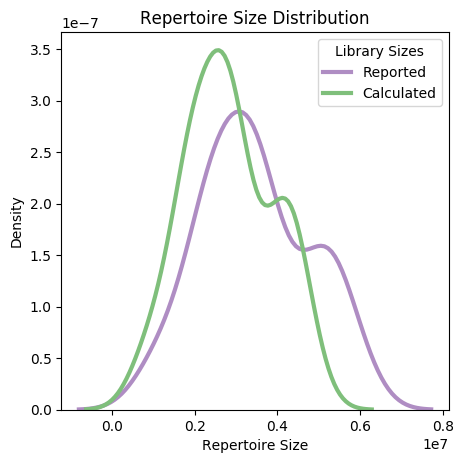

In [156]:
fig, ax = plt.subplots( figsize=(5,5), dpi=100 )
g = sns.distplot( HPV_metadata.loc[:,"total_reads"], 
                 hist=False, 
                 kde=True, 
                 bins=30, 
                 color = '#af8dc3',
                 kde_kws={'linewidth': 3},
                label="Reported")
g1 = sns.distplot( HPV_metadata["Library_Size"], 
                  hist=False, 
                  kde=True, 
                  bins=30, 
                  color = '#7fbf7b',
                  kde_kws={'linewidth': 3},
                  label="Calculated" )

ax.set( xlabel="Repertoire Size", ylabel="Density", title="Repertoire Size Distribution" )
ax.legend( title="Library Sizes")
plt.show()

We see that the reported library sizes are overestimated from what is present in the clonotype tables. I have subsetted the libraries so that they're free of non-productive sequences, so that could explain the difference. 

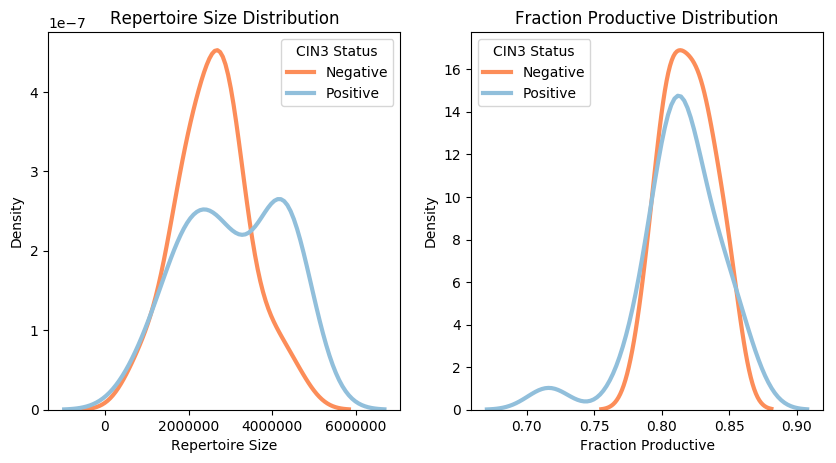

In [159]:
fig, ax = plt.subplots( 1, 2, figsize=(10,5), dpi=100 )
g = sns.distplot( HPV_metadata.loc[HPV_metadata.loc[:,"CIN3_Status"] == "Negative","Library_Size"], 
                 hist=False, 
                 kde=True, 
                 color = '#fc8d59',
                 kde_kws={'linewidth': 3},
                 label="Negative",
                 ax=ax[0] )
g1 = sns.distplot( HPV_metadata.loc[HPV_metadata.loc[:,"CIN3_Status"] == "Positive","Library_Size"], 
                  hist=False, 
                  kde=True, 
                  color = '#91bfdb',
                  kde_kws={'linewidth': 3},
                  label="Positive",
                  ax=ax[0] )
ax[0].set( xlabel="Repertoire Size", ylabel="Density", title="Repertoire Size Distribution" )
ax[0].legend( title="CIN3 Status" )

g2 = sns.distplot( HPV_metadata.loc[HPV_metadata.loc[:,"CIN3_Status"] == "Negative","fraction_productive"], 
                 hist=False, 
                 kde=True, 
                 color = '#fc8d59',
                 kde_kws={'linewidth': 3},
                 label="Negative",
                 ax=ax[1] )
g3 = sns.distplot( HPV_metadata.loc[HPV_metadata.loc[:,"CIN3_Status"] == "Positive","fraction_productive"], 
                  hist=False, 
                  kde=True, 
                  color = '#91bfdb',
                  kde_kws={'linewidth': 3},
                  label="Positive",
                  ax=ax[1] )
ax[1].set( xlabel="Fraction Productive", ylabel="Density", title="Fraction Productive Distribution" )
ax[1].legend( title="CIN3 Status" )
plt.show()

Interestingly, we do see some difference in the distribution of library sizes. The distribution of repertoire sizes within the CIN3 negative cohort are pretty normally distributed while those for the CIN3 positive cohort are bimodal. This is only displaying the number of reads per repertoire though, so this is just a result of uneven sequencing. We can confirm that this is just a technical effect and not biological, but comparing the fraction of each repertoire which is productive. This value should be similar for all repertoires as it is not influenced by any type of selection.

## Association of TCR repertoire diversity and CIN3+ development
This is an analysis which is performed in the paper, but they combine all cases and controls and plot that rarefraction curve. We need to downsample down to the lowest repertoire. We can then present all rarefraction curves and if thats not informative enough then we can just show the case vs control curve like they do in the paper.

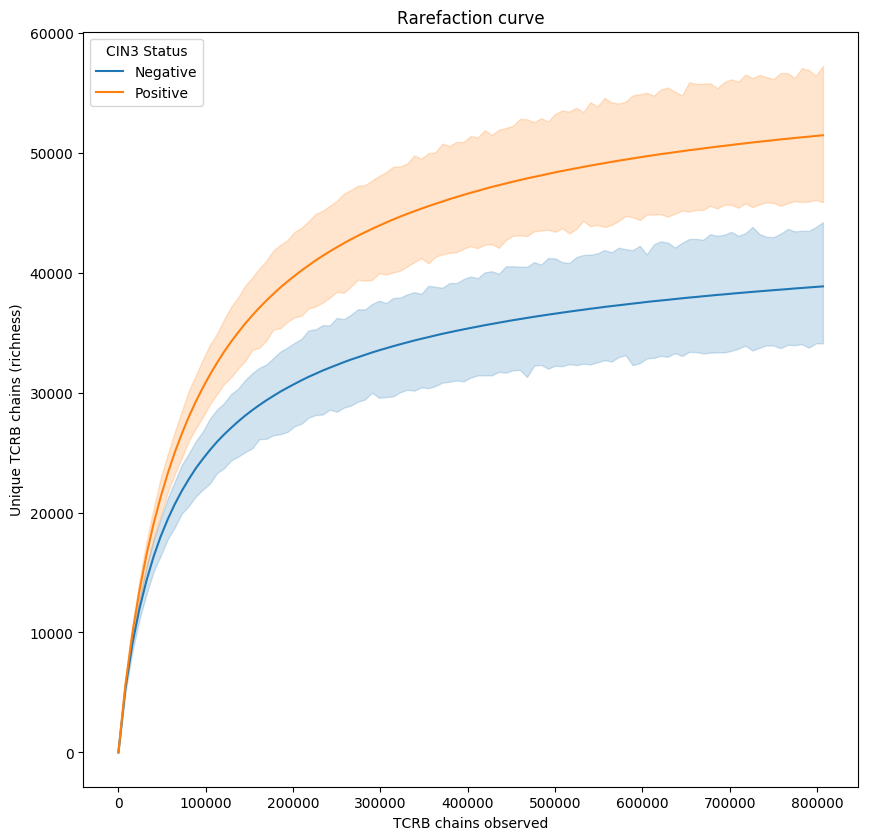

In [46]:
# Rarefaction Analysis - skikit-bio rarefaction is absolutely useless. See if we can't do it faster
rarefaction_analysis = pd.read_csv( "output/rarefaction_output.csv" )
            
rarefaction_analysis.columns = ["sample", "subsample", "rf_value", "rf_error" ]

rarefaction_analysis["CIN3_Status"] = list( HPV_metadata.loc[rarefaction_analysis["sample"]]["CIN3_Status"] == "Positive" )

fig, ax = plt.subplots( figsize=(10,10), dpi=100)
g1 = sns.lineplot( x="subsample", y="rf_value",
                  data=rarefaction_analysis,
                  hue="CIN3_Status",
                  legend=False )

    
ax.set( xlabel="TCRB chains observed", ylabel="Unique TCRB chains (richness)", title="Rarefaction curve" )
ax.legend( loc="upper left", labels=[ "Negative", "Positive" ], title="CIN3 Status")
plt.show()

This is a really interesting result right off the bat. We can see that patients who developed cancer have a more diverse repertoire, as determined with rarefaction, that patients who didn't develop cancer.

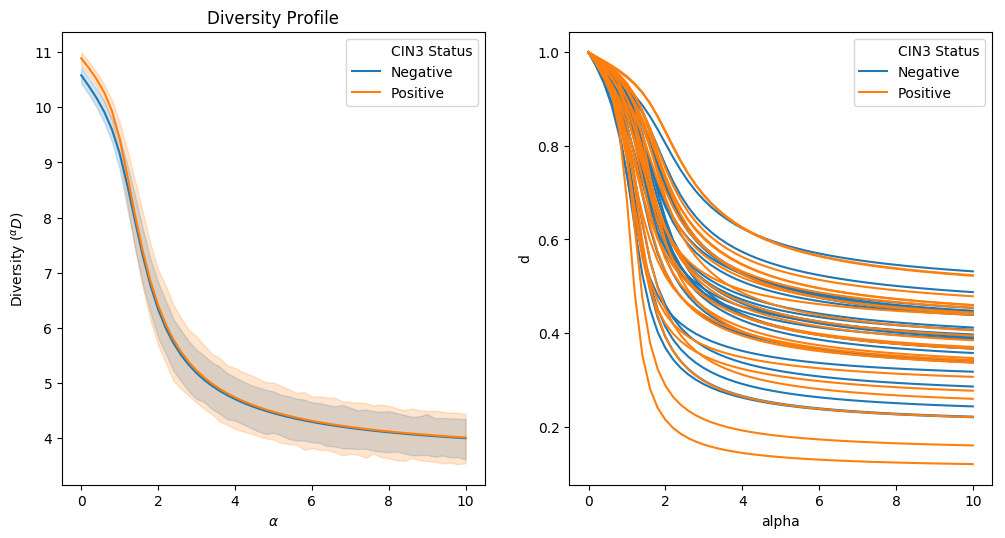

In [148]:
# Diversity Profiles Analysis

# Generate a diversity profile DataFrame.
xlabels = ["d{:.1f}".format( i ) for i in repertoire_list[1].diversity_alpha]
diversity_profiles = pd.DataFrame( [i.diversity for i in repertoire_list],
                                  columns=xlabels,
                                 index=HPV_repes )
diversity_profiles["sample"] = HPV_repes
diversity_profiles["CIN3_Status"] = HPV_metadata.loc[:,"CIN3_Status"]

eveness_profiles = pd.DataFrame( [i.eveness for i in repertoire_list],
                               columns=xlabels,
                               index=HPV_repes )
eveness_profiles["sample"] = HPV_repes
eveness_profiles["CIN3_Status"] = HPV_metadata.loc[:,"CIN3_Status"]

long_dp = pd.wide_to_long( diversity_profiles, 
                          stubnames="d", 
                          i=["sample", "CIN3_Status"], 
                          j="alpha", 
                          suffix='[0-9]+\.?([0-9]+)?' )

long_ep = pd.wide_to_long( eveness_profiles, 
                          stubnames="d", 
                          i=["sample", "CIN3_Status"], 
                          j="alpha", 
                          suffix='[0-9]+\.?([0-9]+)?' )

fig, ax = plt.subplots( 1, 2, figsize=(12,6), dpi=100 )

g1 = sns.lineplot( x="alpha", y="d",
             data=long_dp.reset_index(),
             #units="sample", 
             #estimator=None,
             hue="CIN3_Status", ax=ax[0] )
legend_text = [ "CIN3 Status", "Negative", "Positive" ]
for i, j in zip( g1.legend_.get_texts(), legend_text): i.set_text( j )
    
g1 = sns.lineplot( x="alpha", y="d",
             data=long_ep.reset_index(),
             units="sample", 
             estimator=None,
             hue="CIN3_Status", ax=ax[1] )
legend_text = [ "CIN3 Status", "Negative", "Positive" ]
for i, j in zip( g1.legend_.get_texts(), legend_text): i.set_text( j )
    
ax[0].set( xlabel=r"$\alpha$", ylabel=r"Diversity ($^\alpha D$)", title="Diversity Profile" )
plt.show()

/Users/natem/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  del sys.path[0]


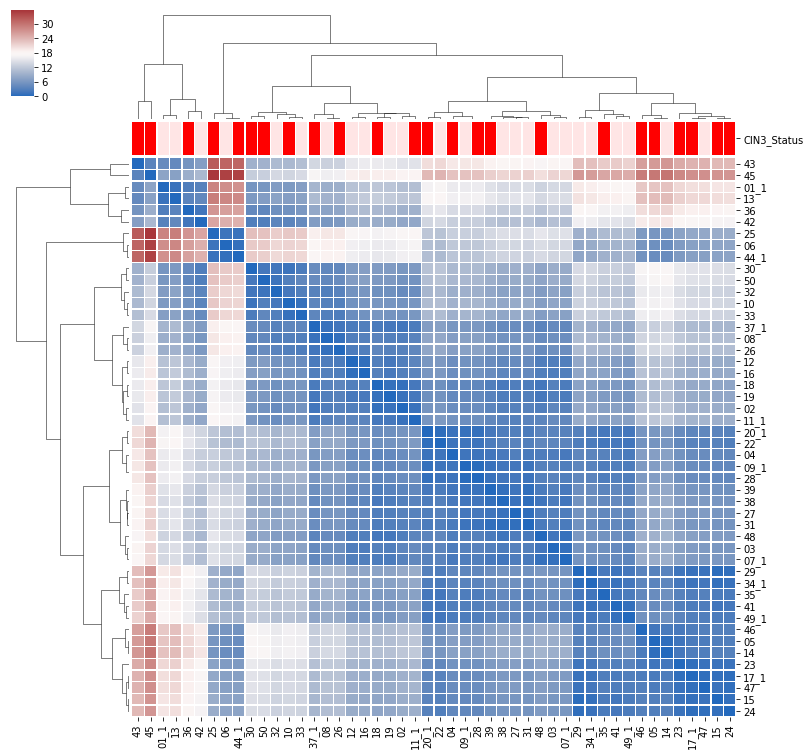

In [399]:
diversity_profiles = pd.DataFrame( [i.diversity for i in repertoire_list],
                                  columns=xlabels,
                                 index=HPV_repes )

dm = pd.DataFrame( sp.distance_matrix( diversity_profiles.values, diversity_profiles.values ), 
             index=diversity_profiles.index, 
             columns=diversity_profiles.index )

cohort_pal = sns.light_palette( 'red', len( HPV_metadata.CIN3_Status.unique() ) )
cohort_lut = dict( zip( HPV_metadata.CIN3_Status.unique(), cohort_pal))
cohort_colors = pd.Series( HPV_metadata.CIN3_Status ).map( cohort_lut )

linkage = hc.linkage( dm, method="complete" )

sns.clustermap( dm,
               row_linkage=linkage,
               col_linkage=linkage,
               cmap="vlag",
               col_colors=cohort_colors,
               linewidth=0.25,
               figsize=(13,13) )

I'd like to perform logistic regression to determine if any diversity measure can be used to confirm what the rarefraction curve showed (that individuals that developed CIN3 had a more diverse repertoire). Unfortunately, Logistic regression in R is not as easy as it is in R. So some options are to use rpy2 to use the glm function of R, or to do a chisquared on each factor to see if there is a difference.

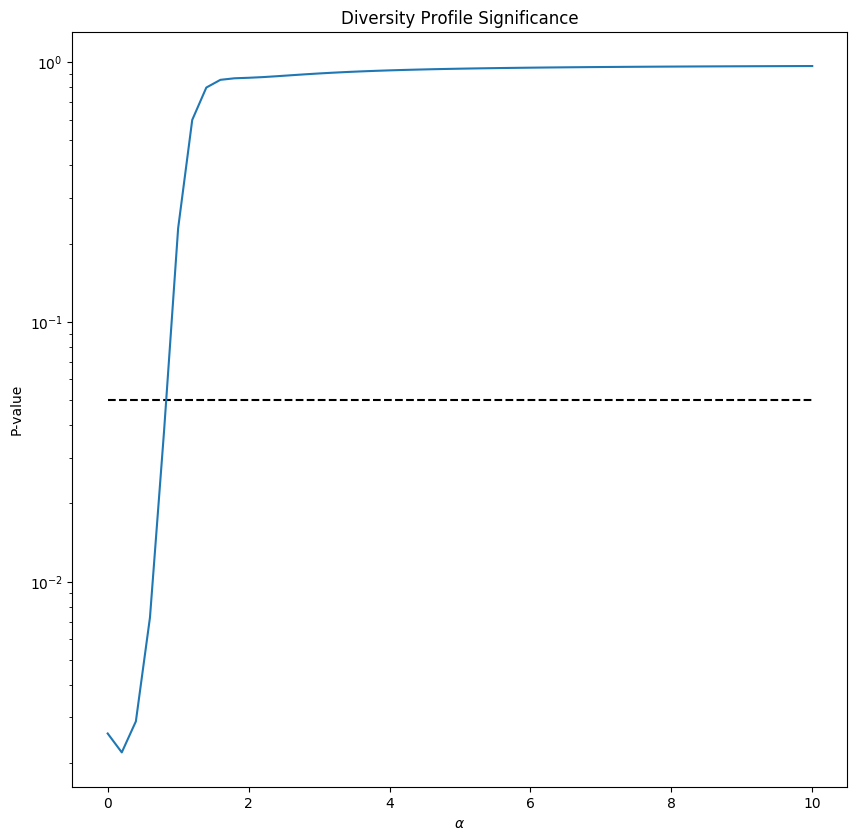

In [171]:


x_cols = ['d0.0', 'd0.2', 'd0.4', 'd0.6', 'd0.8', 'd1.0', 'd1.2', 'd1.4', 'd1.6',
       'd1.8', 'd2.0', 'd2.2', 'd2.4', 'd2.6', 'd2.8', 'd3.0', 'd3.2', 'd3.4',
       'd3.6', 'd3.8', 'd4.0', 'd4.2', 'd4.4', 'd4.6', 'd4.8', 'd5.0', 'd5.2',
       'd5.4', 'd5.6', 'd5.8', 'd6.0', 'd6.2', 'd6.4', 'd6.6', 'd6.8', 'd7.0',
       'd7.2', 'd7.4', 'd7.6', 'd7.8', 'd8.0', 'd8.2', 'd8.4', 'd8.6', 'd8.8',
       'd9.0', 'd9.2', 'd9.4', 'd9.6', 'd9.8', 'd10.0']
y_cols = ["CIN3_Status"]

y_cols = diversity_profiles[y_cols].replace( {"CIN3_Status" : {"Positive" : True, "Negative" : False } } )

scores, pvalues = f_regression( diversity_profiles[x_cols], np.ravel( y_cols ) )

fig, ax = plt.subplots( figsize=(10,10), dpi=100)
sns.lineplot( x=repertoire_list[0].diversity_alpha, y=pvalues )
ax.set( yscale="log", xlabel=r"$\alpha$", ylabel="P-value", title="Diversity Profile Significance" )
ax.hlines( 0.05, 0, 10, linestyles="dashed" )
plt.show()

So I need to come up with a way to display this, but the conclusion I'm drawing from these two analyses is that repertoires from individuals who developed CIN3 are more diverse than those that just cleared HPV. Furthermore, this increase in diversity is largely driven by increased diversity in the more clonally expanded receptors. Not sure how this makes sense logically. Could oncogenesis be immune-driven in this case. Increased T cell clonality increases the probability of developing CIN3

One possible explaination here is that the repertoires were sampled at different times. What we're seeing here could just be the fact that CIN3 positive individuals were sampled at the visit when the lesion was first discovered, and CIN3 negative individuals were sampled at the visit when HPV was no longer detected. It makes sense then that cancer is going to cause an increased immune response in contrast to the convalescence period of an infection.

## Association of VDJ gene usage within the TCR CDR3 β-chain and CIN3+ development


In [417]:
# Sample Pairings:
negative = [ '09_1',
            '31',
            '19',
            '22',
            '49_1',
            '14',
            '16',
            '06',
            '08',
            '29',
            '27',
            '02',
            '12',
            '07_1',
            '47',
            '03',
            '01_1',
            '13',
            '34_1',
            '32',
            '38',
            '41',
            '33',
            '42' ]  
positive = [ '11_1',
            '46',
            '05',
            '23',
            '30',
            '10',
            '48',
            '25',
            '45',
            '43',
            '18',
            '20_1',
            '24',
            '17_1',
            '21',
            '37_1',
            '28',
            '44_1',
            '50',
            '26',
            '39',
            '15',
            '35',
            '36' ]

# Construct large clonotype table. Initally make a list of lists containing data for each clones.
clone_table = list()
for i in repertoire_list:
    i_name = i.name
    i_cohort = HPV_metadata.loc[i_name,"CIN3_Status"]
    for j in i.clonotypes:
        clone_table.append( [j.cdr3aa, j.count, j.freq, j.v_segment, j.d_segment, j.j_segment, i_name, i_cohort] )
        
# Convert the list of lists into a dataframe.
clone_table = pd.DataFrame( clone_table, columns=[ "cdr3aa", "count", "freq", "v_segment", "d_segment", "j_segment", "sample", "CIN3_Status"] )

# Generate a pivot table which summarizes the repertoire composition by vdj segment usage.
segment_table = pd.pivot_table( clone_table, values='count', index=['v_segment', 'd_segment', 'j_segment'], columns=['sample'], aggfunc=np.sum, fill_value=0 )

# Convert the pivot table into a frequency table.
freq_segment_table = segment_table.apply( lambda x : x / sum( x ), axis="index" )

# Run a ttest on each VDJ recombination to see if statistically different usage is present between
# CIN3 positive and negative individuals.
test_table = freq_segment_table.apply( lambda x : wilcoxon( x[positive], x[negative] ), axis="columns" )
test_table = test_table.apply( pd.Series )
test_table.columns = ["statistic", "pvalue"]

# Adjust the pvalues for multiple hypothesis testing
test_table["adj_pvalue"] = multipletests( list( test_table["pvalue"] ), method="fdr_bh" )[1]

# Do the same but test whether removing unresolved genes is chill or not.
segment_table_resolved = segment_table.iloc[["unresolved" not in i for i in segment_table.index]]
freq_segment_table_resolved = segment_table_resolved.apply( lambda x : x / sum( x ), axis="index" )
test_table_unresolved = freq_segment_table_resolved.apply( lambda x : wilcoxon( x[negative], x[positive] ), axis="columns" )
test_table_unresolved = test_table_unresolved.apply( pd.Series )
test_table_unresolved.columns = ["statistic", "pvalue"]
test_table_unresolved["adj_pvalue"] = multipletests( list( test_table_unresolved["pvalue"] ), method="fdr_bh" )[1]

print( "Segment usage differences including unresolved chains:")
print( test_table.sort_values( "adj_pvalue" ).head() )
print()
print( "Segment usage differences excluding unresolved chains:")
print( test_table_unresolved.sort_values( "adj_pvalue" ).head() )


/usr/local/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Segment usage differences including unresolved chains:
                                  statistic    pvalue  adj_pvalue
v_segment  d_segment  j_segment                                  
TCRBV07-08 unresolved TCRBJ01-06       45.0  0.002700     0.52327
TCRBV28-01 unresolved TCRBJ02-07       42.0  0.002031     0.52327
TCRBV25-01 TCRBD02-01 TCRBJ02-07       32.0  0.001264     0.52327
TCRBV24-01 TCRBD02-01 TCRBJ02-05       44.0  0.002457     0.52327
TCRBV23-01 TCRBD02-01 TCRBJ02-07       41.0  0.001844     0.52327

Segment usage differences excluding unresolved chains:
                                  statistic    pvalue  adj_pvalue
v_segment  d_segment  j_segment                                  
TCRBV07-08 TCRBD02-01 TCRBJ01-04       23.0  0.000285    0.369637
TCRBV24-01 TCRBD01-01 TCRBJ02-07       54.0  0.006091    0.459169
TCRBV06-07 TCRBD01-01 TCRBJ02-01       12.0  0.006406    0.459169
TCRBV24-01 TCRBD02-01 TCRBJ02-05       54.0  0.006091    0.459169
TCRBV25-01 TCRBD02-01 TCRBJ02-0

As in the original paper, we don't see any clear differences in VDJ recombination between the CIN3 positive and negative cohorts. Recombination frequence for all samples was calculated and then a wilcoxon signed-rank test was performed to determined differences between cohorts. We used the wilcoxon signed-rank test to correct for confounding effects between cohorts. Samples were paired based on age, smoker status, and pregnancies. In that order.

Many p-values are less than 0.05, but any type of multiple hypothesis testing renders them insignificant. 

Next we can look at the individual segment usage and whether that has an effect. 


In [416]:
v_segment_pt = pd.pivot_table( clone_table, 
                              values='count', 
                              index='v_segment', 
                              columns='sample', 
                              aggfunc=np.sum, 
                              fill_value=0 )

v_segment_pt = v_segment_pt.apply( lambda x : x / sum( x ), axis="index" )
v_segment_pt = v_segment_pt.apply( lambda x : wilcoxon( x[positive], x[negative] ), axis="columns" )
v_segment_pt = v_segment_pt.apply( pd.Series )
v_segment_pt.columns = ["statistic", "pvalue"]
v_segment_pt["adj_pvalue"] = multipletests( list( v_segment_pt["pvalue"] ), method="fdr_bh" )[1]

print( "V segment usage differences (including unresolved):")
print( v_segment_pt.sort_values( "adj_pvalue" ).head() )

print()
j_segment_pt = pd.pivot_table( clone_table, 
                              values='count', 
                              index='j_segment', 
                              columns='sample', 
                              aggfunc=np.sum, 
                              fill_value=0 )

j_segment_pt = j_segment_pt.apply( lambda x : x / sum( x ), axis="index" )
j_segment_pt = j_segment_pt.apply( lambda x : wilcoxon( x[positive], x[negative] ), axis="columns" )
j_segment_pt = j_segment_pt.apply( pd.Series )
j_segment_pt.columns = ["statistic", "pvalue"]
j_segment_pt["adj_pvalue"] = multipletests( list( j_segment_pt["pvalue"] ), method="fdr_bh" )[1]

print( "J segment usage differences (including unresolved):")
print( j_segment_pt.sort_values( "adj_pvalue" ).head() )
print()
v_segment_pt_r = pd.pivot_table( clone_table, 
                              values='count', 
                              index='v_segment', 
                              columns='sample', 
                              aggfunc=np.sum, 
                              fill_value=0 )

v_segment_pt_r = v_segment_pt_r.iloc[["unresolved" not in i for i in v_segment_pt_r.index]]
v_segment_pt_r = v_segment_pt_r.apply( lambda x : x / sum( x ), axis="index" )
v_segment_pt_r = v_segment_pt_r.apply( lambda x : wilcoxon( x[positive], x[negative] ), axis="columns" )
v_segment_pt_r = v_segment_pt_r.apply( pd.Series )
v_segment_pt_r.columns = ["statistic", "pvalue"]
v_segment_pt_r["adj_pvalue"] = multipletests( list( v_segment_pt_r["pvalue"] ), method="fdr_bh" )[1]

print( "V segment usage differences (excluding unresolved):")
print( v_segment_pt_r.sort_values( "adj_pvalue" ).head() )

print()
j_segment_pt_r = pd.pivot_table( clone_table, 
                              values='count', 
                              index='j_segment', 
                              columns='sample', 
                              aggfunc=np.sum, 
                              fill_value=0 )

j_segment_pt_r = j_segment_pt_r.apply( lambda x : x / sum( x ), axis="index" )
j_segment_pt_r = j_segment_pt_r.apply( lambda x : wilcoxon( x[positive], x[negative] ), axis="columns" )
j_segment_pt_r = j_segment_pt_r.apply( pd.Series )
j_segment_pt_r.columns = ["statistic", "pvalue"]
j_segment_pt_r["adj_pvalue"] = multipletests( list( j_segment_pt_r["pvalue"] ), method="fdr_bh" )[1]

print( "J segment usage differences (excluding unresolved):")
print( j_segment_pt_r.sort_values( "adj_pvalue" ).head() )

/usr/local/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


V segment usage differences (including unresolved):
            statistic    pvalue  adj_pvalue
v_segment                                  
TCRBV02-01       72.0  0.025842    0.268761
TCRBV06-07       70.0  0.022271    0.268761
TCRBV05-08       71.0  0.023999    0.268761
TCRBV07-08       58.0  0.008574    0.268761
unresolved       66.0  0.016395    0.268761

J segment usage differences (including unresolved):
            statistic    pvalue  adj_pvalue
j_segment                                  
TCRBJ01-05       76.0  0.034491    0.482872
TCRBJ01-01      125.0  0.475051    0.909011
TCRBJ01-02      140.0  0.775097    0.909011
TCRBJ01-03      142.0  0.819202    0.909011
TCRBJ01-04      118.0  0.360567    0.909011



/usr/local/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


V segment usage differences (excluding unresolved):
            statistic    pvalue  adj_pvalue
v_segment                                  
TCRBV07-08       56.0  0.007237    0.369112
TCRBV06-07       67.0  0.017719    0.451847
TCRBV10-01       80.0  0.045500    0.464103
TCRBV07-06       80.0  0.045500    0.464103
TCRBV05-08       79.0  0.042502    0.464103

J segment usage differences (excluding unresolved):
            statistic    pvalue  adj_pvalue
j_segment                                  
TCRBJ01-05       76.0  0.034491    0.482872
TCRBJ01-01      125.0  0.475051    0.909011
TCRBJ01-02      140.0  0.775097    0.909011
TCRBJ01-03      142.0  0.819202    0.909011
TCRBJ01-04      118.0  0.360567    0.909011


Interestingly, one of the papers only conclusions is that TRBV6-7 is the only segment whose usage is significantly associated with CIN3 status. I cannot reproduce this, though I don't have the pairings that they used in the paper. I paired sequences by sorting CIN3 positive and negative cohorts by age, smoker status, and pregnancies in that order of importance. A few segments have p-values less than 0.05, but either FDR or Bonferonni render them unsignificant.

## Association of TCR β-chain CDR3 sequence and CIN3+ development

### Sequence Based Analysis - Morisita's Overlap

In [1]:
comp1 = comparitor

### Subsequence Based Analysis